#MLP CODE

In [286]:
import os #please ensure random seeding
os.environ['PYTHONHASHSEED'] = '50'

In [287]:
#import required libaries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import pickle
from tqdm import tqdm_notebook
import copy
from google.colab import files

In [288]:
np.random.seed(50)

In [289]:
# Generate all possible 10-digit binary numbers
def generate_all_binary_numbers():
    binary_numbers = []
    for i in range(2 ** 10):
        binary_str = format(i, '010b')
        binary_numbers.append([int(bit) for bit in binary_str])
    return np.array(binary_numbers)

# Generate all possible binary numbers
all_binary_numbers = generate_all_binary_numbers()
np.random.seed(50)
np.random.shuffle(all_binary_numbers)
def is_palindrome(binary_number):
    return int(np.array_equal(binary_number, binary_number[::-1]))

labels = np.array([is_palindrome(x) for x in all_binary_numbers])

In [290]:

!rm -rf "/content/history" #remove directory history if already existent

In [291]:

! mkdir history #make directory history

In [292]:

class MLP():

    """
    This is the MLP class used to feedforward and backpropagate the network across a defined number
    of iterations and produce predictions. After iteration the predictions are assessed using
    Binary Cross Entropy Cost function.
    """

    print('Running...')

    def __init__(self, X, Y, epochs=1000, lr=1e-2, input_layer = 10,n_neurons = 5,output_layer =1,momentum=0.95,num_folds=4,batch_size=18):
        self.X= X#design matrix attibute
        self.epochs = epochs #iterations attibute
        self.lr = lr #learning rate attibute
        self.momentum = momentum #momentum rate attribute
        self.input_layer = input_layer #input layer attibute
        self.n_neurons = n_neurons #hidden layer attibute
        self.output_layer = output_layer #output layer attibute
        min=-1
        max=1
        '''self.w1 = np.random.rand(self.input_layer, self.n_neurons)
        self.w2 = np.random.rand(self.n_neurons, 1)'''
        np.random.seed(5)
        self.w1 = np.random.uniform(min,max,size=(10, self.n_neurons)) #weight initialization from input to hidden layer #np.random.randn(self.input_layer, self.n_neurons)
        np.random.seed(5)
        self.w2 = np.random.uniform(min,max,size=(self.n_neurons, self.output_layer)) #weight initialization from hidden layer to output layer
        #self.w2 = #np.random.randn(self.n_neurons, self.output_layer)#weight attribute connecting to the output layer
        np.random.seed(5)
        self.b1 = np.random.randn(1,self.n_neurons) #bias initialization from input to hidden layer
        np.random.seed(5)
        self.b2 = np.random.randn(1,1) #bias initialization from  hidden layer to output layer
        self.velocity_w1 = np.zeros_like(self.w1) #weight1 velocity initialization
        self.velocity_w2 = np.zeros_like(self.w2) #weight2 velocity initialization
        self.velocity_b1 = np.zeros_like(self.b1) #bias1 velocity initialization
        self.velocity_b2 = np.zeros_like(self.b2) #bias2 velocity initialization
        self.cost = [] #cost list attribute
        self.y_hats = [] #predictions list attribute
        self.acc=[]
        self.precision=[]
        self.recall=[]
        self.y_hats_test=[]
        self.acc_test=[]
        self.precision_test=[]
        self.recall_test=[]
        self.cost_test=[]
        self.acc_fold=[]
        self.precision_fold=[]
        self.recall_fold=[]
        self.acc_fold_test=[]
        self.precision_fold_test=[]
        self.recall_fold_test=[]
        self.total_cost=[]
        self.cost_fold=[]
        self.num_folds=num_folds
        self.Y = Y
        self.batch_size=batch_size

    def sigmoid(self, x): # sigmoid function used at the hidden layer and output layer
        #return 1 / (1 + np.exp(-x))
        return np.exp(-np.logaddexp(0, -x))

    def sigmoid_derivative(self, x): # sigmoid derivative used for backpropgation
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    def relu(self, x):
        return np.maximum(x,0)

    def relu_derivative(self,x):
        return np.greater(x, 0).astype(int)
    def tanh(self,x):
         return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


    def tanh_derivative(self,x):
         return 1 - self.tanh(x) * self.tanh(x)

    def forward_propagation(self,X):#define function to feedforward the network
        self.a_1 = X
        self.z_1 = self.w1.T @ self.a_1 + self.b1.T #linear transformation to the hidden layer
        self.a_2 = self.relu(self.z_1) #hidden layer activation function
        self.z_2 = self.w2.T @self.a_2 + self.b2.T #linear transformation to the output layer
        self.y_hat = self.sigmoid(self.z_2) #output layer prediction
        return self.a_1,self.z_1, self.a_2, self.z_2, self.y_hat

    def BCECost(self, y, y_hat): # binary cross entropy cost function
        bce_cost = -(y * np.log(y_hat+1e-6) + (1 - y) * np.log(1 - y_hat+1e-6))
        return bce_cost

    def backword_prop(self, a_1,z_1, a_2 , z_2, y_hat,y): #backpropagation
        error = y_hat - y
        self.dw2 =  error @ self.a_2.T #derivative of loss w.r.t weight2
        self.db2 = error #derivative of loss w.r.t bias2
        self.dw1 = (self.w2 @ error * self.relu_derivative(self.z_1)) @ self.a_1.T #derivative of loss w.r.t weight1
        self.db1 = (self.w2 @ error * self.relu_derivative(self.z_1)) #derivative of loss w.r.t bias1
        return self.dw1.T, self.dw2.T,self.db1.T,self.db2

    def inference(self,x_test,y_test,k):
      self.cost_test=[]
      self.y_hats_test=[]
      for i in range(x_test.shape[0]):
              a_1,z_1, a_2, z_2, y_hat_test = self.forward_propagation(x_test[i].reshape(-1,1))
              self.cost_test.append(self.BCECost(y_test[i].reshape(-1,1), y_hat_test))#store BCE costper sample in list
              self.y_hats_test.append(0 if y_hat_test<0.5 else 1)#store predictions in list
      print(f"fold:{k}, precision: {precision_score(y_test,self.y_hats_test,zero_division=0)}, acc: {accuracy_score(y_test,self.y_hats_test)}, recall:{recall_score(y_test,self.y_hats_test)}, loss:{np.mean(self.cost_test)} ")
      self.acc_test.append(accuracy_score(y_test,self.y_hats_test))
      self.precision_test.append(precision_score(y_test,self.y_hats_test,zero_division=0))
      #print(self.y_hats_test,y_test)
      self.recall_test.append(recall_score(y_test,self.y_hats_test))

    def plot(self,fold,cost,epoch):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epoch+1), cost,label="loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss over Epochs for fold{fold+1}')
        plt.legend()
        plt.show()
        plt.savefig(f'history/{self.n_neurons}_loss_fold{fold}_us.png')
        files.download(f'history/{self.n_neurons}_loss_fold{fold}_us.png')

    def reset(self):
        """This helps resetting the weights after completition of run over one folds"""
        min=-1 #(1/np.sqrt(10))
        max=1 #/np.sqrt(10)
        np.random.seed(10)
        #self.w1 = np.random.rand(self.input_layer, self.n_neurons)
        #self.w2 = np.random.rand(self.n_neurons, 1)
        self.w1 = np.random.uniform(min,max,size=(10, self.n_neurons)) #np.random.randn(self.input_layer, self.n_neurons)
        np.random.seed(5)
        self.w2 = np.random.uniform(min,max,size=(self.n_neurons, self.output_layer))
        np.random.seed(5)
        self.b1 = np.random.randn(1,self.n_neurons)
        np.random.seed(5)
        self.b2 = np.random.randn(1,1)
        self.velocity_w1 = np.zeros_like(self.w1)
        self.velocity_w2 = np.zeros_like(self.w2)
        self.velocity_b1 = np.zeros_like(self.b1)
        self.velocity_b2 = np.zeros_like(self.b2)


    def train(self):#train the network
        skf = StratifiedKFold(n_splits=4)
        ros = RandomOverSampler(sampling_strategy="not majority") #random oversampling tried but not implemented in this code
        for fold,(train_index, test_index) in enumerate(skf.split(self.X, self.Y)):
            #print("len of train_index",len(train_index))
            #print("len of test_index",len(test_index))
            x_train_unsampled, x_test = self.X[train_index], self.X[test_index]
            y_train_unsampled, y_test = self.Y[train_index], self.Y[test_index]
            x_train, y_train = x_train_unsampled, y_train_unsampled #ros.fit_resample(
            self.total_cost=[]
            self.acc=[]
            self.precision=[]
            self.recall=[]
            for epoch in  tqdm_notebook(range(self.epochs)):
              self.y_hats=[]
              self.cost=[]
              for i in range(x_train.shape[0]):
                      a_1,z_1, a_2, z_2, y_hat = self.forward_propagation(x_train[i].reshape(-1,1))# feedforward
                      dw1, dw2,db1,db2 = self.backword_prop(a_1,z_1, a_2, z_2, y_hat,y_train[i].reshape(-1,1))#backpropgate
                      self.velocity_w1 = self.momentum*self.velocity_w1 +(1-self.momentum)*dw1
                      self.velocity_w2 = self.momentum*self.velocity_w2 +(1-self.momentum)*dw2
                      self.velocity_b1 = self.momentum*self.velocity_b1 - self.lr*db1
                      self.velocity_b2 = self.momentum*self.velocity_b2 - self.lr*db2
                      self.w1 -= self.lr*self.velocity_w1#update weights connecting to the hidden layer (gradient descent)
                      self.w2 -= self.lr*self.velocity_w2#update weights connecting to the output layer (gradient descent )
                      self.b1 += self.velocity_b1
                      self.b2 += self.velocity_b2
                      self.cost.append(self.BCECost(y_train[i].reshape(-1,1), y_hat))#store BCE cost per sample in list
                      self.y_hats.append(0 if y_hat<0.5 else 1)#store predictions per sample in list
              self.acc.append(accuracy_score(y_train,self.y_hats))#store accuracy per epoch
              self.precision.append(precision_score(y_train,self.y_hats,zero_division=0))#store precision per epoch
              self.recall.append(recall_score(y_train,self.y_hats))#store recall per epoch
              self.total_cost.append(np.mean(self.cost))#store cost per epoch
              file_name_epoch = f'history/fold_{fold}.txt'
              with open(file_name_epoch,'a') as text_file:
                text_file.write(f'epoch: {epoch}, precision: {precision_score(y_train,self.y_hats,zero_division=0)}, acc: {accuracy_score(y_train,self.y_hats)}, recall: {recall_score(y_train,self.y_hats)}, loss: {np.mean(self.cost)}\n')
              if epoch%100==0:
                print(f"epoch: {epoch}, precision: {precision_score(y_train,self.y_hats,zero_division=0)}, acc: {accuracy_score(y_train,self.y_hats)}, recall: {recall_score(y_train,self.y_hats)}, loss: {np.mean(self.cost)}")
            file_name = f'history/fold_{fold}_model.pkl'
            model = copy.deepcopy(self)
            with open(file_name, 'wb') as file:
                pickle.dump(model, file)
                print(f'Weights successfully saved to "{file_name}"')
            print(f'Train_precision: {np.mean(self.precision)}, Train_accuracy: {np.mean(self.acc)}, Train_recall: {np.mean(self.recall)}, Train_loss: {np.mean(self.total_cost)},')
            model.inference(x_test,y_test,fold) #run model inference on test fold
            self.plot(fold,self.total_cost,self.epochs) #plot loss for fold1
            self.reset() #reset weights before running next fold






        print('Training Complete')
        print('----------------------------------------------------------------------------')

# Prepare the XOR Logic Gate data: create an array for each training example x feature, and an array for each corrosponding y label.
'''X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]]) #input features (4 x 2 design matrix)
Y = np.array([[1], [1], [0], [0]])#ground truth y labels (4x1)'''




Running...


'X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]]) #input features (4 x 2 design matrix)\nY = np.array([[1], [1], [0], [0]])#ground truth y labels (4x1)'

<ipython-input-292-052965ef8c2b>:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in  tqdm_notebook(range(self.epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0, precision: 0.14285714285714285, acc: 0.9622395833333334, recall: 0.041666666666666664, loss: 0.15866131138894538
epoch: 100, precision: 1.0, acc: 0.9700520833333334, recall: 0.041666666666666664, loss: 0.09769072268233242
epoch: 200, precision: 1.0, acc: 0.9791666666666666, recall: 0.3333333333333333, loss: 0.06688419422792458
epoch: 300, precision: 1.0, acc: 0.9908854166666666, recall: 0.7083333333333334, loss: 0.033196151506087394
epoch: 400, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.005866532233207852
epoch: 500, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0029644691000515317
epoch: 600, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.001921053169475279
epoch: 700, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.001433184109704071
epoch: 800, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.001124504625271735
epoch: 900, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0009235606239806991
Weights successfully saved to "history/fold_0_model.pkl"
Train_precision: 0.9069803

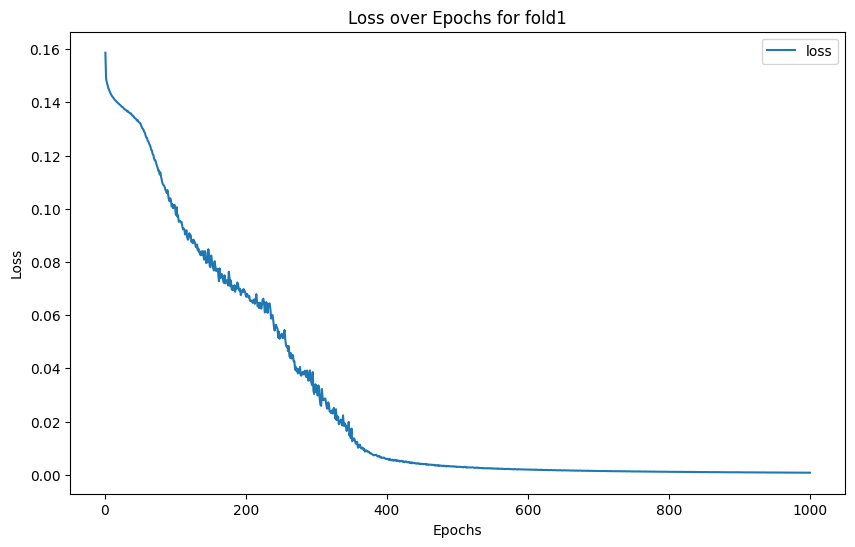

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-292-052965ef8c2b>:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in  tqdm_notebook(range(self.epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0, precision: 0.0, acc: 0.9661458333333334, recall: 0.0, loss: 0.15920619076714734
epoch: 100, precision: 0.0, acc: 0.96875, recall: 0.0, loss: 0.07354110783202557
epoch: 200, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.012398168693360414
epoch: 300, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0038898471249138723
epoch: 400, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.002051384977828349
epoch: 500, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.001329765547983183
epoch: 600, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0009887343261621813
epoch: 700, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0007753346983073182
epoch: 800, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0006411365231684786
epoch: 900, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.000532596960406244
Weights successfully saved to "history/fold_1_model.pkl"
Train_precision: 0.8886885448916408, Train_accuracy: 0.9959348958333333, Train_recall: 0.870125, Train_loss: 0.016863244201864882,
fold:1, preci

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-292-052965ef8c2b>:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in  tqdm_notebook(range(self.epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0, precision: 0.0, acc: 0.9661458333333334, recall: 0.0, loss: 0.165207784947051
epoch: 100, precision: 0.0, acc: 0.96875, recall: 0.0, loss: 0.09762364275782032
epoch: 200, precision: 1.0, acc: 0.99609375, recall: 0.875, loss: 0.024905986871821013
epoch: 300, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.004257268401705251
epoch: 400, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.002159178623999875
epoch: 500, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0014367751337956913
epoch: 600, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.001059563991034125
epoch: 700, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0008345767803800636
epoch: 800, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0006777862991923659
epoch: 900, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0005686664443446282
Weights successfully saved to "history/fold_2_model.pkl"
Train_precision: 0.8612573257023335, Train_accuracy: 0.9949361979166668, Train_recall: 0.8397083333333334, Train_loss: 0.0202853506679923

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-292-052965ef8c2b>:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in  tqdm_notebook(range(self.epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0, precision: 0.0, acc: 0.9661458333333334, recall: 0.0, loss: 0.16444554086654498
epoch: 100, precision: 0.0, acc: 0.96875, recall: 0.0, loss: 0.10504122358548297
epoch: 200, precision: 0.8, acc: 0.97265625, recall: 0.16666666666666666, loss: 0.0753163017581252
epoch: 300, precision: 0.75, acc: 0.9765625, recall: 0.375, loss: 0.057388427119988906
epoch: 400, precision: 0.7, acc: 0.9739583333333334, recall: 0.2916666666666667, loss: 0.07145586433883365
epoch: 500, precision: 1.0, acc: 0.9856770833333334, recall: 0.5416666666666666, loss: 0.0465193749858169
epoch: 600, precision: 1.0, acc: 0.9947916666666666, recall: 0.8333333333333334, loss: 0.021179145653911616
epoch: 700, precision: 1.0, acc: 0.9973958333333334, recall: 0.9166666666666666, loss: 0.01648520727279587
epoch: 800, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0012500636857522872
epoch: 900, precision: 1.0, acc: 1.0, recall: 1.0, loss: 0.0008123604709904894
Weights successfully saved to "history/fold_3_model.pkl"


<Figure size 640x480 with 0 Axes>

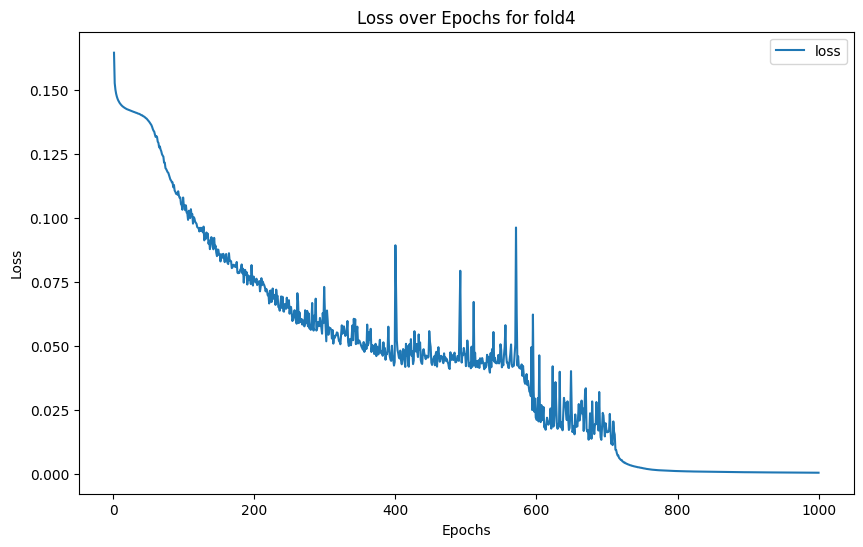

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Complete
----------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [293]:
mlp = MLP(all_binary_numbers,labels)#Pass data to the model (design matrix and y label)
mlp.train() #Train the model

In [294]:
with open("/content/history/fold_3_model.pkl","rb") as f:
  model = pickle.load(f)#load model if present in local directory on colab

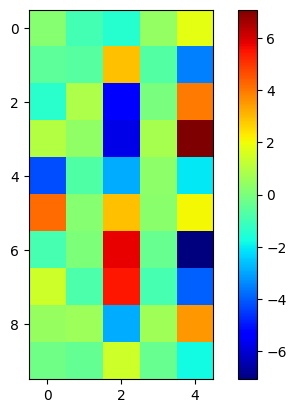

In [295]:
import matplotlib.pyplot as plt
#print("Max = ",np.max(net.w1)," Min = ",np.min(net.w1))
fig= plt.imshow(model.w1,cmap='jet') #visualize weight matrix1
plt.colorbar(fig)
plt.show()


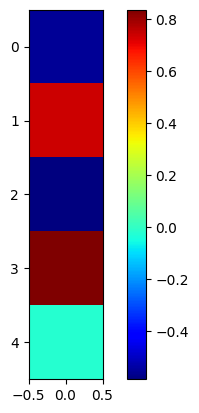

In [296]:
#print("Max = ",np.max(net.w1)," Min = ",np.min(net.w1))
fig= plt.imshow(mlp.w2,cmap='jet') #visualize weight matrix2
plt.colorbar(fig)
plt.show()

#Demo code

In [297]:
import pickle
import numpy as np

In [298]:
!unzip '/content/demo_code_final_16_neurons_history.zip' #unzip the loaded history_5neurons.zip folder

unzip:  cannot find or open /content/demo_code_final_16_neurons_history.zip, /content/demo_code_final_16_neurons_history.zip.zip or /content/demo_code_final_16_neurons_history.zip.ZIP.


In [299]:
with open ('/content/history/fold_2_model.pkl', 'rb' ) as f: #load the model
  model = pickle.load(f)

In [300]:
input = np.array([0,0,1,0,1,1,0,1,0,1]).reshape(-1,1) #provide the input to the list
x,z1,a2,z2,pred = model.forward_propagation(input)
if pred<0.5:
  print("The number isn't palindrome")
else: print("The number is palindrome")

The number isn't palindrome


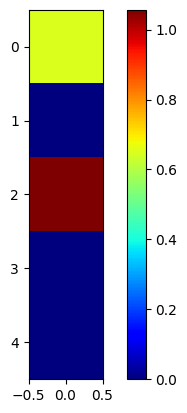

In [301]:
fig= plt.imshow(a2,cmap='jet') #for positive sample the response of hidden layer activations
plt.colorbar(fig)
plt.show()

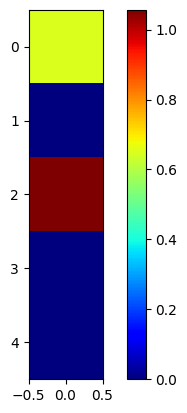

In [302]:
fig= plt.imshow(a2,cmap='jet') #for negative sample the response of hidden layer activations
plt.colorbar(fig)
plt.show()

In [303]:
!zip -r /content/history.zip /content/history #zipping the current history file for download

updating: content/history/ (stored 0%)
updating: content/history/5_loss_fold3_us.png (deflated 90%)
updating: content/history/fold_2.txt (deflated 83%)
updating: content/history/5_loss_fold1_us.png (deflated 90%)
updating: content/history/fold_1_model.pkl (deflated 92%)
updating: content/history/5_loss_fold0_us.png (deflated 90%)
updating: content/history/5_loss_fold2_us.png (deflated 90%)
updating: content/history/fold_0_model.pkl (deflated 91%)
updating: content/history/fold_1.txt (deflated 83%)
updating: content/history/fold_0.txt (deflated 83%)
updating: content/history/fold_2_model.pkl (deflated 91%)
updating: content/history/fold_3_model.pkl (deflated 91%)
updating: content/history/fold_3.txt (deflated 84%)
